<a href="https://colab.research.google.com/github/BStar14/Classical-Quantum_Hybird_CNN/blob/main/03_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd/content/drive/MyDrive/Colab Notebooks/QHK2021/03_test

/content/drive/MyDrive/Colab Notebooks/QHK2021/03_test


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch 
import torch.nn as nn # basic neural network
import torch.nn.functional as F # Convolutional functions
import torch.optim as optim # optimizers
import torch.utils.data as data_utils # data resizer
from torchvision import datasets, transforms # image datasets, image transformations

import pandas as pd

In [ ]:
torch.cuda.is_available()
torch.manual_seed(0)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(0)

In [ ]:
n_epochs = 30     # Number of optimization epochs
n_channels = 25   # Number of channels
n_trn = 50        # Size of the train dataset
n_val = 30        # Size of the validation dataset
batch_size = 10   # Size of batch

np.random.seed(0)           # Seed for NumPy random number generator
n_poly = 3                  # Order of polynomials
rand_params = np.random.uniform(low=-1.0, high=1.0, size=(n_channels, n_poly))

PREPROCESS = False

In [ ]:
trn_dataset = datasets.MNIST('../03_test/',
                             download=True,
                             train=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor()#, # image to Tensor
                                #  transforms.Normalize((0.1307,), (0.3081,)) # mean, std of MNIST.
                             ])) 

val_dataset = datasets.MNIST("../03_test/", 
                             download=False,
                             train=False,
                             transform= transforms.Compose([
                               transforms.ToTensor()#,
                              #  transforms.Normalize((0.1307, ),(0.3081, ))
                           ]))

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
trn_dataset = data_utils.Subset(trn_dataset, range(n_trn))
val_dataset = data_utils.Subset(val_dataset, range(n_val))

# Batch iterator
trn_loader = torch.utils.data.DataLoader(dataset = trn_dataset,
                                         batch_size = batch_size,
                                         shuffle = True)

val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                         batch_size = batch_size,
                                         shuffle = True)

X_train: torch.Size([10, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([10]) type: torch.LongTensor


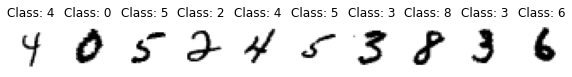

In [ ]:
for (X_train, y_train) in trn_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [ ]:
## Random Polynomial Definition
def rand_poly(x):

  result_array = []
  for i in range(n_channels):
    result = 0
    for j in range(n_poly):
      for k in x:
        result = result + rand_params[i, j] * (k ** j)
    result_array.append(result)

  return np.array(result_array)

In [ ]:
## Apply Nonlinear Filter
def rand_nl(x):
  height = 28
  width = 28
  h = height - 1
  w = width - 1
  center = torch.tensor([0, 0])
  magnitude = 0.15
  n = 5

  # (n-1)th order polynomial
  
  result_tensor = torch.tensor([])
  for i in range(batch_size):
    result3 = np.empty((n_channels, 0, w))
    for j in range(h):
      result2 = np.empty((n_channels, 1, 0))
      for k in range(w):
        result1 = rand_poly(
          [
            x[i, 0, j, k],
            x[i, 0, j, k + 1],
            x[i, 0, j + 1, k],
            x[i, 0, j + 1, k + 1]
          ]
        )
        y = np.expand_dims(x, axis=1)
        result1 = np.expand_dims(result1, axis=(1, 2))
        result2 = np.concatenate((result2, result1), axis=2)
      result3 = np.concatenate((result3, result2), axis=1)
      
    result_tensor = torch.cat((result_tensor, torch.tensor(result3).unsqueeze(0)))
    
    print(f"{(i+1)*10}%")

  return result_tensor

In [ ]:
if PREPROCESS == True:
  nl_trn_images = torch.tensor([])
  for i, data in enumerate(trn_loader):
    x, label = data
    print(f"Processing batch #{i+1}")
    x = rand_nl(x)
    nl_trn_images = torch.cat((nl_trn_images, x))

  torch.save(nl_trn_images, 'nl_trn_images')

In [ ]:
# Load pre-processed images
nl_trn_images = torch.load('nl_trn_images')

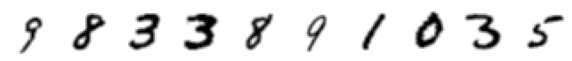

In [ ]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(nl_trn_images[i, 0, :, :].numpy().reshape(27, 27), cmap = "gray_r")

In [ ]:
# construct model on cuda if available
use_cuda = torch.cuda.is_available()

class CNNClassifier(nn.Module):
    
    def __init__(self, model='cnn'):
        super(CNNClassifier, self).__init__()
        
        nl_conv = nn.Conv2d(in_channels=1, out_channels=25, kernel_size=1) # 25@28*28
        nl_conv1 = nn.Conv2d(in_channels=25, out_channels=50, kernel_size=5) # 50@24*24
        conv1 = nn.Conv2d(in_channels=1, out_channels=50, kernel_size=5) # 50@24*24
        pool1 = nn.MaxPool2d(2) # 50@12*12
        conv2 = nn.Conv2d(in_channels=50, out_channels=64, kernel_size=5) # 64@8*8
        pool2 = nn.MaxPool2d(2) # 64@4*4

        fc2 = nn.Linear(1024, 10)

        nn.init.xavier_uniform_(nl_conv.weight)
        nn.init.xavier_uniform_(nl_conv1.weight)
        nn.init.xavier_uniform_(conv1.weight)
        nn.init.xavier_uniform_(conv2.weight)
        nn.init.xavier_uniform_(fc2.weight)

        if model == 'random':
            self.conv_module = nn.Sequential(
                nl_conv1,
                nn.ReLU(),
                pool1,
                conv2,
                nn.ReLU(),
                pool2
            )
        else:
            self.conv_module = nn.Sequential(
                conv1,
                nn.ReLU(),
                pool1,
                conv2,
                nn.ReLU(),
                pool2
            )

        self.fc_module = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.ReLU(),
            fc2
        )
        
        # cuda
        if use_cuda:
            self.conv_module = self.conv_module.cuda()
            self.fc_module = self.fc_module.cuda()
        
    def forward(self, x):
        out = self.conv_module(x)
        # 64@4*4
        out = out.view(out.size(0), -1) # 1*1024
        out = self.fc_module(out)
        return F.softmax(out, dim=1)

In [ ]:
def save_data_file(file_name, classifier = CNNClassifier(), verbose=False, model='', **kwargs):
  criterion = nn.CrossEntropyLoss()
  learning_rate = 1e-3
  num_epochs = 1
  
  optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)
  num_batches = len(trn_loader)

  trn_loss_list = []
  val_loss_list = []
  trn_acc_list = []
  val_acc_list = []

  for epoch in range(num_epochs):
    trn_loss = 0.0
    correct = 0.0
    for i, data in enumerate(trn_loader):
      x, label = data

      if model == 'random':
        x = nl_trn_images[i*10:i*10+9, :, :, :]
        
      if use_cuda:
        x = x.cuda()
        label = label.cuda()
      
      optimizer.zero_grad()
      
      model_output = classifier(x)
      _, predicted = torch.max(model_output.data, 1)
      
      loss = criterion(model_output, label)
      loss.backward()
      optimizer.step()
      
      trn_loss += loss.item()
      correct += (predicted == label).float().sum()/batch_size

      del loss
      del model_output
      del predicted

      if (i+1) % 100 == 0 or i == 0:
        with torch.no_grad():
          val_loss = 0.0
          val_correct = 0.0
          for j, val in enumerate(val_loader):
            val_x, val_label = val
            if use_cuda:
              val_x = val_x.cuda()
              val_label =val_label.cuda()
            val_output = classifier(val_x)
            _, val_predicted = torch.max(val_output.data, 1)
            v_correct = (val_predicted == val_label).float().sum()/batch_size
            v_loss = criterion(val_output, val_label)
            val_correct += v_correct
            val_loss += v_loss

        if verbose:            
          print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | trn acc: {:.4f} | val acc: {:.4f}".format(
              epoch+1, num_epochs, i+1, num_batches, trn_loss / 100, val_loss / len(val_loader), correct / 100, val_correct / len(val_loader)
          ))
        elif (i+1) % 1000 == 0:
          print(f'Progress: {(i+1)/num_batches:.2f} %')            
        
        trn_loss_list.append(trn_loss/100)
        val_loss_list.append(val_loss/len(val_loader))
        trn_acc_list.append(correct /100)
        val_acc_list.append(val_correct / len(val_loader))
        if i==0: continue
        trn_loss = 0.0 
        correct = 0.0

  file = pd.DataFrame(data={'trn_loss': trn_loss_list,
                            'trn_acc': trn_acc_list,
                            'val_loss': val_loss_list,
                            'val_acc': val_acc_list})
  file.to_pickle('drive/MyDrive/Colab Notebooks/QHK2021/03_test/'+file_name)
  


In [ ]:
cnn = CNNClassifier()
nl_cnn = CNNClassifier(model='random')
print(cnn)
print(nl_cnn)

CNNClassifier(
  (conv_module): Sequential(
    (0): Conv2d(1, 50, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(50, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_module): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)
CNNClassifier(
  (conv_module): Sequential(
    (0): Conv2d(25, 50, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(50, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_module): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): ReLU()
    (2): Linear(in_features=1024, out

In [ ]:
save_data_file('qlassifier_data_unit_cnn.pkl', verbose=False, model='')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


FileNotFoundError: ignored

In [ ]:
save_data_file('qlassifier_data_unit_nlcnn.pkl', verbose=False, model='random')

RuntimeError: ignored

In [ ]:
cnn_data = pd.read_pickle('drive/MyDrive/Colab Notebooks/QHK2021/jade_cnn_test/qlassifier_data_unit_cnn.pkl')
nlcnn_fisheye_data = pd.read_pickle('drive/MyDrive/Colab Notebooks/QHK2021/jade_cnn_test/qlassifier_data_unit_nlcnn_fisheye.pkl')

In [ ]:
datafile = nlcnn_fisheye_data

plt.figure(1, figsize=(8,4.5))
plt.plot(datafile['trn_acc'], label="Training dataset", color='blue', linestyle='--')
plt.plot(datafile['val_acc'], label="Validation dataset", color='red', linestyle='--')
plt.title('CNN')
plt.legend()
plt.xlim(0, 100)
plt.xticks([0, 20, 40, 60, 80, 100],[0, 2000, 4000, 6000, 8000, 10000])
plt.ylim(0, 1)
plt.xlabel("Training iterations [1]")
plt.ylabel("Accuracy [1]")

plt.figure(2, figsize=(8,4.5))
plt.plot(datafile['trn_loss'][1:], label="Training dataset", color='blue', linestyle='--')
plt.plot(datafile['val_loss'][1:], label="Validation dataset", color='red', linestyle='--')
plt.title('CNN')
plt.legend()
plt.xlim(0, 100)
plt.xticks([0, 20, 40, 60, 80, 100],[0, 2000, 4000, 6000, 8000, 10000])
# plt.ylim(0, 1)
plt.xlabel("Training iterations [1]")
plt.ylabel("Cross entropy loss [1]")
plt.show()

In [ ]:
plt.figure(3, figsize=(8,4.5))
plt.plot(cnn_data['val_acc'], label="CNN", linestyle='--')
plt.plot(nlcnn_fisheye_data['val_acc'], label="Fisheye", linestyle='--')
plt.legend()
plt.title('UN Dist. #F = 25')
plt.xlim(0, 100)
plt.xticks([0, 20, 40, 60, 80, 100],[0, 2000, 4000, 6000, 8000, 10000])
plt.ylim(0, 1)
plt.xlabel("Training iterations [1]")
plt.ylabel("Validation accuracy [1]")

plt.figure(4, figsize=(8,4.5))
plt.plot(cnn_data['trn_loss'][1:], label="CNN", linestyle='--')
plt.plot(nlcnn_fisheye_data['trn_loss'][1:], label="Fisheye", linestyle='--')
plt.legend()
plt.title('UN Dist. #F = 25')
plt.xlim(0, 100)
plt.xticks([0, 20, 40, 60, 80, 100],[0, 2000, 4000, 6000, 8000, 10000])
# plt.ylim(0, 1)
plt.xlabel("Training iterations [1]")
plt.ylabel("Cross entropy loss (training) [1]")
plt.show()